# Assignment

The following notebook contains the base architecture for the assignment.

The task is to complete the missing parts, explore the datasets and build two simple binary classifier, one which consists only of fully connected layers and one which also incorporates convolutional and max-pooling layers.

Only numpy is allowed to implement the classes! (Matplotlib and other modules can be used for visualization and data exploration.)

**Due date:** 2019 december 3

In [0]:
import numpy as np

# Optimizers

In [0]:
class Optimizer:
  def update(self, param, grad):
    pass
  
  def __call__(self, param, grad):
    self.update(param, grad)
  
  
class SGD(Optimizer):
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
  
  def update(self, param, grad):
    '''Gradient Descent Update
    This function updates the given 'param' using the 'grad' (gradients). 
    Note #1: Use the learning_rate. 
    Note #2: There are no return values.
    :param param: Parameters of the layer.
    :param grad: Corresponding gradients.
    '''
    param -= self.learning_rate * grad

# Weight Initializers

In [0]:
class WeigthInitializer:
  def initialize(self, size):
    return np.ones(size, dtype=np.float)
  
  def __call__(self, size):
    return self.initialize(size)
  

class RandomInitializer(WeigthInitializer):
  def __init__(self, shift=-0.5, scale=0.2):
    self.shift = shift
    self.scale = scale
    
  def initialize(self, size):
    '''Random number initializer
    Note #1: 'self.scale' specifies the range of the values and with 'self.shift' they can be shifted.
    Note #2: By default (with scale=0.2 and shift=-0.5) it should return a matrix which contains random values between -0.1 and 0.1. 
    Note #3: Use the np.random modul!

    :param size: Dimensions of the matrix.
    :returns: A matrix of random numbers with dimensions specified by 'size'. 
    '''
    return self.scale *(np.random.random(size) + self.shift)

class HeInitializer(WeigthInitializer):
  def __init__(self, shift=-0.5, scale=0.2):
    self.shift = shift
    self.scale = scale
    
  def initialize(self, size):
    '''He initializer
    :param size: Dimensions of the matrix.
    :returns: A matrix of random numbers with dimensions specified by 'size'. 
    '''
    if (len(size) == 2):
      return 0.5 * np.random.standard_normal(size) * np.sqrt(2.0/(size[0]))
    elif (len(size) == 4):
      return 0.5 * np.random.standard_normal(size) * np.sqrt(2.0/(size[0]*size[1]*size[2]))

# Function class

In [0]:
class Function:
  def forward(self, input):
    return None  
  
  def __call__(self, input):
    return self.forward(input)
  
  def backward(self, grads):
    return None

## Activation functions

In [0]:
class Activation(Function):
  def __init__(self):
    pass
  
  
class Linear(Activation):
  def forward(self, z):
    return z.astype(np.float)

  def backward(self, z):
    return np.ones_like(z, dtype=np.float)


class Relu(Activation):
  def forward(self, z):
    '''Forward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU(z), see the lecture notes for the definition. 
    '''
    return np.maximum(0,z).astype(np.float)

  def backward(self, z):
    '''Backward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU'(z), see the lecture notes for the definition. 
    '''
    z[z > 0] = 1
    z[z <= 0] = 0
    return z.astype(float)


class Sigmoid(Activation):
  def forward(self, z):
    '''Forward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid(z), see the lecture notes for the definition. 
    '''
    z = 1 / (1 + np.exp(-z))
    return z.astype(float)
  
  def backward(self, z):
    '''Backward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid'(z), see the lecture notes for the definition. 
    '''
    z = 1 / (1 + np.exp(-z)) * (1 - 1 / (1 + np.exp(-z)))
    return z.astype(float)

## Loss functions

In [0]:
class Loss(Function):
  def forward(self, y_true, y_pred):
    return None
  
  def __call__(self, y_true, y_pred):
    return self.forward(y_true, y_pred)
  
  def backward(self, y_true, y_pred):
    return None
  
  
class BinaryCrossentropy(Loss):
  def forward(self, y_true, y_pred):
    '''Forward pass of the Binary Crossentropy loss.
    Note: Both 'y_true' and 'y_pred' contains a batch of labels => y_true.shape == y_pred.shape == <batch size> x 1 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Binary crossentropy loss, see the lecture notes for the definition. 
    '''
    return np.sum(-1*y_true*np.log10(y_pred)-(1-y_true)*np.log10(1-y_pred)) / len(y_true)

  def backward(self, y_true, y_pred):
    '''Backward pass of the Binary Crossentropy loss.
    Note #1: The gradient should have the same shape as y_pred (<batch size> x 1) 
    Note #2: Keep in mind that the derivative of the loss in the lecture notes is for a logistic regression model. 
    Note #3: Here, you do not need to derive respect to the weights! 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Derivative of the binary crossentropy loss, see the lecture notes for the "definition". 
    '''
    return y_true*(y_pred-1) + (1-y_true)*y_pred

## Layers

In [0]:
class Layer(Function):
  def __init__(self, activation, optimizer=None, weight_init=HeInitializer(), *args, **kwargs):
    self.activation = activation
    self.optimizer = optimizer
    self.weight_init = weight_init
  
  def _forward(self, x):
    return None
  
  def forward(self, X):
    self.X = X
    self.Z = self._forward(X)
    self.h = self.activation(self.Z)
    return self.h
  
  def _backward(self, dZ):
    return None, None
  
  def backward(self, dh):
    dZ = dh * self.activation.backward(self.Z)
    self.dX, self.grads = self._backward(dZ)
    self._update_weights()
    return self.dX
  
  def _update_weights(self):
    assert len(self.params) == len(self.grads)
    for idx in range(len(self.params)):
      self.optimizer(self.params[idx], self.grads[idx])

### Fully-connected (dense) layer

In [0]:
class Dense(Layer):
  def __init__(self, size, *args, **kwargs):
    super(Dense, self).__init__(*args, **kwargs)
    self.W = self.weight_init(size)
    self.b = self.weight_init((1, size[1]))
    self.params = [self.W, self.b]
    
  def _forward(self, X):
    '''Forward pass of the dense layer.
    Note #1: Use self.W and self.b
    Note #2: Input times weight add a bias ==> activate is already taken care of! (see self.forward())

    :param X: Input matrix
    :returns: Linear combination, see the lecture notes for the definition.
    '''
    return np.dot(X, self.params[0]) + self.params[1]

  def _backward(self, dZ):
    '''Backward pass of the dense layer.
    Note: Use self.X

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and [dW, db]) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''
    dW = np.dot(self.X.T, dZ) / len(dZ)
    db = np.dot(np.ones(len(dZ)), dZ) / len(dZ)
    dX = np.transpose(np.dot(self.params[0], dZ.T))
    return dX, [dW, db]

### Flatten

In [0]:
class Flatten(Layer):
  def __init__(self, *args, **kwargs):
    super(Flatten, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    return X.reshape((len(X), -1))

  def _backward(self, dZ):
    return dZ.reshape(self.X.shape), []
  
  def _update_weights(self):
    pass

### Max pooling

In [0]:
class Maxpool2d(Layer):

  def __init__(self, *args, **kwargs):
    super(Maxpool2d, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    '''Forward pass of the max pooling layer.

    :param X: Input matrix
    :returns: Matrix (<batch_size> x <height>//2 x <width>//2 x <n_channels>) after max pooling, see the lecture notes for the definition.
    '''    
    self.mask = np.zeros((X.shape[0], X.shape[1], X.shape[2], X.shape[3]))
    new_X = np.zeros((X.shape[0], int(X.shape[1]/2), int(X.shape[2]/2), X.shape[3]))
    for i in range(int(X.shape[1]/2)):
      for j in range(int(X.shape[1]/2)):
        for n in range(X.shape[0]):
          for c in range(X.shape[3]):
            new_X[n, i, j, c] = np.max(X[n, 2*i:2*i+2, 2*j:2*j+2, c])
            pos = np.argmax(X[n, 2*i:2*i+2, 2*j:2*j+2, c])
            if (pos == 0):
              self.mask[n, 2*i, 2*j, c] = 1
            elif (pos == 1):
              self.mask[n, 2*i, 2*j+1, c] = 1
            elif (pos == 2):
              self.mask[n, 2*i+1, 2*j, c] = 1
            elif (pos == 3):
              self.mask[n, 2*i+1, 2*j+1, c] = 1
    return new_X

  def _backward(self, dZ):
    '''Backward pass of the max pooling layer.
    Note: Use self.mask too.

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and []) which contains the partial derivative respect to the input and an empty list. See the lecture notes for the "definition".
    '''
    dX = np.zeros((dZ.shape[0], 2*dZ.shape[1], 2*dZ.shape[2], dZ.shape[3]))
    for i in range(dZ.shape[1]):
      for j in range(dZ.shape[2]):
        for n in range(dZ.shape[0]):
          for c in range(dZ.shape[3]):
            if (self.mask[n, 2*i, 2*j, c] == 1):
              dX[n, 2*i, 2*j, c] = dZ[n, i, j, c]
              dX[n, 2*i, 2*j+1, c] = 0
              dX[n, 2*i+1, 2*j, c] = 0
              dX[n, 2*i+1, 2*j+1, c] = 0
            elif (self.mask[n, 2*i, 2*j+1, c] == 1):
              dX[n, 2*i, 2*j+1, c] = dZ[n, i, j, c]
              dX[n, 2*i, 2*j, c] = 0
              dX[n, 2*i+1, 2*j, c] = 0
              dX[n, 2*i+1, 2*j+1, c] = 0
            elif (self.mask[n, 2*i+1, 2*j, c] == 1):
              dX[n, 2*i+1, 2*j, c] = dZ[n, i, j, c]
              dX[n, 2*i, 2*j+1, c] = 0
              dX[n, 2*i, 2*j, c] = 0
              dX[n, 2*i+1, 2*j+1, c] = 0
            elif (self.mask[n, 2*i+1, 2*j+1, c] == 1):
              dX[n, 2*i+1, 2*j+1, c] = dZ[n, i, j, c]
              dX[n, 2*i, 2*j+1, c] = 0
              dX[n, 2*i+1, 2*j, c] = 0
              dX[n, 2*i, 2*j, c] = 0
    return dX, []
    
  def _update_weights(self):
    pass

### Convolutional layer

In [0]:
class Conv2d(Layer):
  def __init__(self, kernel_size, n_channels, n_kernels, pad, use_fast=False, *args, **kwargs):    
    super(Conv2d, self).__init__(*args, **kwargs)
    self.W = self.weight_init((kernel_size, kernel_size, n_channels, n_kernels))
    self.b = self.weight_init((1, 1, 1, n_kernels))
    self.params = [self.W, self.b]
    self.pad = pad
    self.use_fast = use_fast
  
  def _convolution_fast(self, Y):
    '''Optimized version of the convolution operation (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: It's an optional task.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''    
    pass
    
  def _convolution_slow(self, Y):
    '''Naive version (with a bunch of for loops) of the convolution operation.
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: Both convolution and cross-correlation is acceptable.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''   
    a = int((self.params[0].shape[0]-1)/2)
    b = int((self.params[0].shape[1]-1)/2)
    c = self.params[0].shape[3]
    for k in range(self.params[0].shape[3]):
      for z in range(self.X.shape[3]):
        for i in range(a, self.X.shape[0]-a):
          for j in range(b, self.X.shape[1]-b):
            Y[i][j][k] = np.sum(np.multiply(self.X[i-a:i+a+1,j-b:j+b+1,:,z],self.params[0][:,:,:,k]))
  
  def _forward(self, X):
    y_height = X.shape[1] - self.params[0].shape[0] + 2*self.pad + 1
    y_width = X.shape[2] - self.params[0].shape[1] + 2*self.pad + 1
    Y = np.zeros((X.shape[0], y_height, y_width, self.params[0].shape[3]), dtype=np.float16)
    
    if 0 < self.pad:
      X_padded = np.pad(X, ((0,0),(self.pad,self.pad),(self.pad,self.pad),(0,0)), mode = 'constant')
    else:
      X_padded = X
    self.X_padded = X_padded
    
    if self.use_fast:
      self._convolution_fast(Y)
    else:
      self._convolution_slow(Y)
    
    Y += self.b
    return Y
  
  def _backward_fast(self, dZ):
    '''Optimized version of the backward pass (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: It's an optional task.
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''    
    db = None
    dW = None
    dX = None
    return dX, dW, db

  def _backward_slow(self, dZ):
    '''Naive version (with a bunch of for loops) of the backward pass.
    Note: Use self.X, self.X_padded, self.W
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''   
    dW = np.zeros((self.params[0].shape), dtype=np.float16)
    db = np.zeros((self.params[0].shape), dtype=np.float16)
    dX = np.zeros((dZ.shape), dtype=np.float16)

    a = int((self.params[0].shape[0]-1)/2)
    b = int((self.params[0].shape[1]-1)/2)
    c = self.params[0].shape[2]
    m = self.X.shape[0]
    k = self.params[0].shape[3]
    self.X = np.resize(self.X, (dZ.shape))
    self.params[1] = np.resize(self.params[1], ((self.params[0].shape)))

    dZ = np.transpose(dZ, (1,2,0,3))
    self.X = np.transpose(self.X, (1,2,0,3))

    for i in range(a, self.X.shape[0] - a):
      for j in range(b, self.X.shape[1] - b):
        for mi in range(m):
          dW = 1/m * np.multiply(self.X[i-a:i+a+1,j-b:j+b+1,mi,:],dZ[i-a:i+a+1,j-b:j+b+1,mi,:])
          dW = np.expand_dims(dW, axis=2)

    for mi in range(m):
      for i in range(self.X.shape[0]):
        for j in range(self.X.shape[1]):
          db = 1/m * dZ[0:self.params[0].shape[0],0:self.params[0].shape[1],mi,:]
          db = np.expand_dims(db, axis=2)

    for i in range(a, self.X.shape[0] - a):
      for j in range(b, self.X.shape[1] - b):
        for mi in range(m):
          for ki in range(k):
            dX[mi][i][j] = np.sum(np.multiply(dZ[i-a:i+a+1,j-b:j+b+1,:,ki], self.params[0][:,:,:,ki]))

    dX = np.resize(dX, (dX.shape[0], dX.shape[1], dX.shape[2], int(dX.shape[3]/2)))

    return dX, dW, db
  
  def _backward(self, dZ):
    if self.use_fast:
      dX, dW, db = self._backward_fast(dZ)
    else:
      dX, dW, db = self._backward_slow(dZ)
    
    return dX, [dW, db]
    

# Model class

In [0]:
import matplotlib.pyplot as plt

class Model:
  def __init__(self, layers=None, loss=None, optimizer=None):
    self.layers = []
    if layers is not None:
      self.layers = layers
    self.loss = loss
    self.optimizer = optimizer
    self.losses = []
  
  def add(self, layer):
    assert isinstance(layer, Layer)
    layer.optimizer = self.optimizer
    self.layers.append(layer)
  
  def train(self, x_train, y_train, n_epochs, batch_size, randomize=True, display=True):
    self.losses = []   
    n_layers = len(self.layers)
    for epoch in range(n_epochs):
      idx_list = list(range(len(x_train)))
      if randomize:
        np.random.shuffle(idx_list)
      n_batches = (len(idx_list) + batch_size - 1) // batch_size
      loss = 0
      for batch_idx in range(n_batches):
        data = x_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]]
        
        # forward pass
        for i in range(n_layers):
          data = self.layers[i].forward(X=data)
          
        # loss
        y_pred = data
        y_true = y_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]].reshape(len(y_pred),1)
        batch_loss = self.loss(y_true, y_pred)
        loss += batch_loss
        
        # backward pass
        back = [self.loss.backward(y_true,y_pred)]
        for i in range(n_layers):
          back.append(self.layers[n_layers-1-i].backward(dh=back[i]))

        # display
        # print('Epoch {}/{}: batch {}/{}: batch_loss: {}, avg_loss: {}'.format(epoch+1, n_epochs, batch_idx+1, n_batches, batch_loss, loss/(batch_idx+1)))  #, end='\r')
      
      print('Epoch {}/{}: loss: {}'.format(epoch+1, n_epochs, loss/n_batches))
      self.losses.append(loss / n_batches)

    if display:
      plt.plot(range(n_epochs), self.losses, label='train loss', color='blue')
      plt.title('Learning Curve Plot')
      plt.xlabel('Number of Epochs')
      plt.ylabel('Loss')
      plt.show()
  
  def predict(self, x_test, y_test, display=True):
    idx_list = list(range(len(x_test)))
    data = x_test[idx_list]

    # forward pass
    for i in range(len(self.layers)):
      data = self.layers[i].forward(data)
    
    y_pred = data
    y_true = y_test[idx_list]

    # precision and recall
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for y in range(y_pred.shape[0]):
      if y_pred[y] > 0.5 and y_true[y] == 1:
        tp = tp + 1
      elif y_pred[y] < 0.5 and y_true[y] == 1:
        fn = fn + 1
      elif y_pred[y] > 0.5 and y_true[y] == 0:
        fp = fp + 1
      else:
        tn = tn + 1
    
    print("The number of True Positives is: " + str(tp))
    print("The number of False Negatives is: " + str(fn))
    print("The number of False Positives is: " + str(fp))
    print("The number of True Negatives is: " + str(tn))

    if tp > 0 or fp > 0:
      precision = tp / (tp + fp)
      print("The precision is: " + str(precision))
    else:
      print("The precision could not be computed")

    if tp > 0 or fn > 0:
      recall = tp / (tp + fn)
      print("The recall is: " + str(recall))
    else:
      print("The recall could not be computed")

    if tp > 0 or fn > 0 or tn > 0 or fp > 0:
      accuracy = (tp + tn) / (fp + fn + tp + tn)
      print("The accuracy is: " + str(accuracy))
    else:
      print("The accuracy could not be computed")

# Breast Cancer Wisconsin (Diagnostic) Dataset

For more information, see: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [14]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

--2019-12-11 13:05:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124103 (121K) [application/x-httpd-php]
Saving to: ‘wdbc.data’

wdbc.data           100%[===================>] 121.19K  --.-KB/s    in 0.09s   

2019-12-11 13:05:34 (1.33 MB/s) - ‘wdbc.data’ saved [124103/124103]



In [15]:
filename = 'wdbc.data'

with open(filename, 'r') as file:
  lines = file.readlines()
  
words = [line.split(',') for line in lines]
data = words[:-1]

features = [[float(item) for item in rec[2:]] for rec in data]
features = np.array(features, dtype=np.float32)

label_str_to_num = lambda label: 1. if label == 'M' else 0.
labels = [label_str_to_num(rec[1]) for rec in data]
labels = np.array(labels, dtype=np.float32)

# removing records with missing features (if any feature == 0.)
missing_features = np.any(features == 0., axis=1)
features = features[~missing_features,:]
labels = labels[~missing_features]

print(features.shape)
print(labels.shape)

(556, 30)
(556,)


## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Print the scales of each features. (min, max, avg, std)
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data by each feature. (Use Z-score standardization.)

Print labels distribution

In [16]:
print("Number of instances is "+ str(len(labels)))
print("Number of instances whose label is 1: " +str(len(labels[labels==1])))
print("Number of instances whose label is 0: " +str(len(labels[labels==0])))

Number of instances is 556
Number of instances whose label is 1: 212
Number of instances whose label is 0: 344


Print the scales of each features. (min, max, avg, std)

In [17]:
print("Number of features is "+ str(features.shape[1]))
print("The maximum value for each of the features is the following:")
print(np.max(features, axis=0))
print("The minimum value for each of the features is the following:")
print(np.min(features, axis=0))
print("The average value for each of the features is the following:")
print(np.average(features, axis=0))
print("The standard deviation for each of the features is the following:")
print(np.std(features, axis=0))

Number of features is 30
The maximum value for each of the features is the following:
[2.811e+01 3.928e+01 1.885e+02 2.501e+03 1.634e-01 3.454e-01 4.268e-01
 2.012e-01 3.040e-01 9.744e-02 2.873e+00 3.568e+00 2.198e+01 5.422e+02
 3.113e-02 1.354e-01 3.960e-01 5.279e-02 7.895e-02 2.984e-02 3.604e+01
 4.954e+01 2.512e+02 4.254e+03 2.226e-01 1.058e+00 1.252e+00 2.910e-01
 6.638e-01 2.075e-01]
The minimum value for each of the features is the following:
[7.691e+00 9.710e+00 4.834e+01 1.704e+02 6.251e-02 1.938e-02 6.920e-04
 1.852e-03 1.167e-01 4.996e-02 1.115e-01 3.602e-01 7.570e-01 6.802e+00
 2.667e-03 2.252e-03 6.920e-04 1.852e-03 7.882e-03 8.948e-04 8.678e+00
 1.202e+01 5.449e+01 2.236e+02 8.125e-02 3.432e-02 1.845e-03 8.772e-03
 1.565e-01 5.504e-02]
The average value for each of the features is the following:
[1.42375622e+01 1.92597542e+01 9.27366486e+01 6.63734619e+02
 9.66164544e-02 1.05678819e-01 9.08755139e-02 5.00629507e-02
 1.81278139e-01 6.27464801e-02 4.06446695e-01 1.19292939e+

Randomly split the dataset to training and test sets. Ratio should be 80% for training and 20% for testing.

In [0]:
from sklearn.model_selection import train_test_split
features_tr, features_te, labels_tr, labels_te = train_test_split(features, labels, test_size=0.20)

Make sure that the distribution of the labels is similar. Print the distribution of the labels.

In [19]:
print("Number of instances whose label is 1 (in train set): " + str(len(labels_tr[labels_tr==1])))
print("Number of instances whose label is 0 (in train set): " + str(len(labels_tr[labels_tr==0])))
print("Number of instances whose label is 1 (in test set): " + str(len(labels_te[labels_te==1])))
print("Number of instances whose label is 0 (in test set): " + str(len(labels_te[labels_te==0])))

Number of instances whose label is 1 (in train set): 171
Number of instances whose label is 0 (in train set): 273
Number of instances whose label is 1 (in test set): 41
Number of instances whose label is 0 (in test set): 71


Normalize the data by each feature, using Z-score standardization.

In [0]:
from scipy import stats
for i in range(features_tr.shape[1]):
  features_tr[:,i] = stats.zscore(features_tr[:,i])
  features_te[:,i] = stats.zscore(features_te[:,i])

## Define and train a model.
Tasks:
* Define a 2 layer fully-connected network:
  1. layer with 5 units and ReLU activation.
  2. layer with 1 units and Sigmoid activation.
* Train it for 500 epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

In [0]:
np.random.seed(20)

Define a 2 layer fully-connected network:

1.   Layer with 5 units and ReLU activation.
2.   Layer with 1 units and Sigmoid activation.

Train it for 500 epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01. Plot the learning curve.

Epoch 1/500: loss: 0.39869742433049415
Epoch 2/500: loss: 0.3796339386343589
Epoch 3/500: loss: 0.3632766903510213
Epoch 4/500: loss: 0.3476009294860561
Epoch 5/500: loss: 0.3336741156860807
Epoch 6/500: loss: 0.3206209042247418
Epoch 7/500: loss: 0.308063255051714
Epoch 8/500: loss: 0.2970070883096348
Epoch 9/500: loss: 0.28724026222144483
Epoch 10/500: loss: 0.2766288040428052
Epoch 11/500: loss: 0.2667118394208182
Epoch 12/500: loss: 0.257057617159338
Epoch 13/500: loss: 0.24781020710934995
Epoch 14/500: loss: 0.23957838008000043
Epoch 15/500: loss: 0.23091366420630063
Epoch 16/500: loss: 0.22322909962648557
Epoch 17/500: loss: 0.21516287114905144
Epoch 18/500: loss: 0.20788864483770622
Epoch 19/500: loss: 0.20092472673650222
Epoch 20/500: loss: 0.19454965907339578
Epoch 21/500: loss: 0.18817872870301544
Epoch 22/500: loss: 0.18205580770200408
Epoch 23/500: loss: 0.17651817083126775
Epoch 24/500: loss: 0.17139577051002883
Epoch 25/500: loss: 0.166588032313744
Epoch 26/500: loss: 0.1

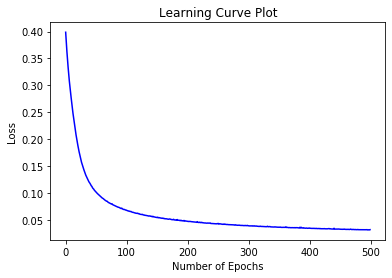

In [22]:
model = Model(layers=None, loss=BinaryCrossentropy(), optimizer=SGD(learning_rate=0.01))
model.add(Dense([features_tr.shape[1], 5], Relu()))
model.add(Dense([5, 1], Sigmoid()))
model.train(features_tr, labels_tr, 500, 16)

Summarize the results for the training part. It is possible to observe the decreasement of the training loss. It is reduced from 0.7 to 0.07 in the 500 epochs required. This type of result means that the efficiency of the solution is quite high, but it has to be evaluated in the following section.

Evaluate the trained model on the test set. Extract and comment interesting metrics, such as loss, accuracy, precision or recall.

In [23]:
model.predict(features_te, labels_te)

The number of True Positives is: 40
The number of False Negatives is: 1
The number of False Positives is: 2
The number of True Negatives is: 69
The precision is: 0.9523809523809523
The recall is: 0.975609756097561
The accuracy is: 0.9732142857142857


The results for the evaluation are really good. On one way, the amount of false negatives and false positives is really low. This means that the output of the binary classifier is correctly predicted with a high probability. All the extracted metrics have an efficiency higher than 95%.

# Triangles vs Circles (Basic Shapes Dataset)

For more information, see: https://www.kaggle.com/cactus3/basicshapes

In [24]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" -o circles_vs_triangles_data.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   2852      0 --:--:-- --:--:-- --:--:--  2852
100  153k  100  153k    0     0   546k      0 --:--:-- --:--:-- --:--:--  149M


In [0]:
import pickle
from __future__ import division

with open('circles_vs_triangles_data.pkl', 'rb') as f:
    data = pickle.load(f)
features, labels = np.array(data['features'], dtype=np.float), data['labels']

In [26]:
features.shape

(200, 28, 28, 1)

## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Plot some images (3 circles and 3 triangles).
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data between -1. and 1. (Use min-max scaling.)

Print the distribution of the labels.

In [27]:
print("Number of instances is "+ str(len(labels)))
print("Number of instances whose label is 1: " +str(len(labels[labels==1])))
print("Number of instances whose label is 0: " +str(len(labels[labels==0])))

Number of instances is 200
Number of instances whose label is 1: 100
Number of instances whose label is 0: 100


Plot some images (3 circles and 3 triangles).

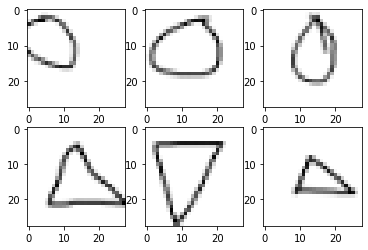

In [28]:
import matplotlib.pyplot as plt
fig=plt.figure()
fig.add_subplot(2,3,1)
plt.imshow(np.array(np.squeeze(features[0], axis=(2,))), cmap='gray')
fig.add_subplot(2,3,2)
plt.imshow(np.array(np.squeeze(features[10], axis=(2,))), cmap='gray')
fig.add_subplot(2,3,3)
plt.imshow(np.array(np.squeeze(features[20], axis=(2,))), cmap='gray')
fig.add_subplot(2,3,4)
plt.imshow(np.array(np.squeeze(features[130], axis=(2,))), cmap='gray')
fig.add_subplot(2,3,5)
plt.imshow(np.array(np.squeeze(features[140], axis=(2,))), cmap='gray')
fig.add_subplot(2,3,6)
plt.imshow(np.array(np.squeeze(features[150], axis=(2,))), cmap='gray')
plt.show()

Normalize the data between -1. and 1, using min-max scaling.

In [0]:
for i in range(features.shape[0]):
  min_val = np.min(features[i])
  max_val = np.max(features[i])
  for j in range(features.shape[1]):
    for k in range(features.shape[2]):
      a = features[i][j][k] - min_val
      b = max_val - min_val
      features[i][j][k] = 2 * (a/b - 0.5)

Randomly split the dataset to training and test sets. Ratio should be 80% for training and 20% for testing.

In [0]:
features_tr, features_te, labels_tr, labels_te = train_test_split(features, labels, test_size=0.20)

Make sure that the distribution of the labels is similar. Print the distribution of the labels.

In [31]:
print("Number of instances whose label is 1 (in train set): " +str(len(labels_tr[labels_tr==1])))
print("Number of instances whose label is 0 (in train set): " +str(len(labels_tr[labels_tr==0])))
print("Number of instances whose label is 1 (in test set): " +str(len(labels_te[labels_te==1])))
print("Number of instances whose label is 0 (in test set): " +str(len(labels_te[labels_te==0])))

Number of instances whose label is 1 (in train set): 80
Number of instances whose label is 0 (in train set): 80
Number of instances whose label is 1 (in test set): 20
Number of instances whose label is 0 (in test set): 20


## Define and train a model.
Tasks:
* Define a simple convolutional network as follows: 2x(Conv2D with 4 [then 8 in the second time] (3x3) kernels -> ReLU -> MaxPooling2D) -> Flatten -> Dense with 32 units -> Relu -> Dense -> Sigmoid
* Train it for 100 (or less if it is too slow...) epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
  * Optional: Also train it with the optimized implementation, and measure the speed up. 
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

In [0]:
np.random.seed(25)

Define a simple convolutional network as follows: 
2x(Conv2D with 4 [then 8 in the second time] (3x3) kernels -> ReLU -> MaxPooling2D) -> Flatten -> Dense with 32 units -> Relu -> Dense -> Sigmoid

Then, train it for 100 (or less if it is too slow...) epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01. 

Finally, plot the learning curve.

Epoch 1/50: loss: 0.34747485367442327
Epoch 2/50: loss: 0.342290514760814
Epoch 3/50: loss: 0.3421286778168617
Epoch 4/50: loss: 0.3342882749915099
Epoch 5/50: loss: 0.33707788377367726
Epoch 6/50: loss: 0.3135736244190284
Epoch 7/50: loss: 0.31773247033981605
Epoch 8/50: loss: 0.3286182018039492
Epoch 9/50: loss: 0.30939485700192054
Epoch 10/50: loss: 0.3032444113007067
Epoch 11/50: loss: 0.32609338892237794
Epoch 12/50: loss: 0.3088775183172207
Epoch 13/50: loss: 0.30108926295099897
Epoch 14/50: loss: 0.3031976278650449
Epoch 15/50: loss: 0.29825448136802046
Epoch 16/50: loss: 0.2822248304921059
Epoch 17/50: loss: 0.30432422752147265
Epoch 18/50: loss: 0.29875918334027496
Epoch 19/50: loss: 0.3024155324849462
Epoch 20/50: loss: 0.27904361162316105
Epoch 21/50: loss: 0.28298829753520566
Epoch 22/50: loss: 0.3061411067482235
Epoch 23/50: loss: 0.28439219991717873
Epoch 24/50: loss: 0.2830958208114206
Epoch 25/50: loss: 0.29523726876355993
Epoch 26/50: loss: 0.3040784818246267
Epoch 27/

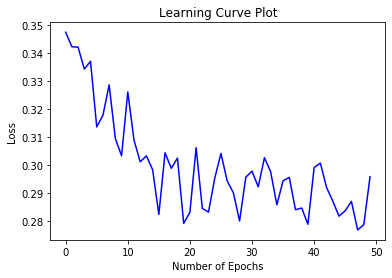

In [33]:
model2 = Model(layers=None, loss=BinaryCrossentropy(), optimizer=SGD(learning_rate=0.01))
model2.add(Conv2d(kernel_size=3, n_channels=1, n_kernels=4, pad=1, activation=Relu()))
model2.add(Maxpool2d())
model2.add(Conv2d(kernel_size=3, n_channels=1, n_kernels=8, pad=1, activation=Relu()))
model2.add(Maxpool2d())
model2.add(Flatten())
model2.add(Dense([392, 32], Relu()))
model2.add(Dense([32, 1], Sigmoid()))
model2.train(features_tr, labels_tr, 50, 16)

The evolution of the learning curve plot throughout 50 epochs show a slow decay of the loss, although it is stable after the first 20 epochs. This means that the neural network is learning, but not too much. Therefore, it could be said that the results are not going to be as good as in the BCWD.

Afterwards, proceed for the evaluation step, applying predict function to this new model.

In [34]:
model2.predict(features_te, labels_te, True)

The number of True Positives is: 11
The number of False Negatives is: 9
The number of False Positives is: 5
The number of True Negatives is: 15
The precision is: 0.6875
The recall is: 0.55
The accuracy is: 0.65


Evaluate the trained model on the test set. The result of the evaluation is not totally good, as the accuracy is lower than 80%. There should be a mistake either in convolutional, in max pooling layer or in the initialization of the project. The mistake could also be in the initialization as the plotted weights are either really small or null.